Kaggle

![OpenAI Logo](./Kaggle.png)

# Module

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import accuracy_score
import wandb
from torchviz import make_dot
from datetime import datetime
import argparse



# 1. Data Set

## 1-1. Titanic Train Data Set

In [4]:
class TitanicDataset(Dataset):
    '''
    Custom dataset class for the Titanic dataset.

    Args:
        X (numpy.ndarray or list): Input features.
        y (numpy.ndarray or list): Target labels.

    Attributes:
        X (torch.Tensor): Input features as a PyTorch FloatTensor.
        y (torch.Tensor): Target labels as a PyTorch LongTensor.
    '''

    def __init__(self, X, y):
        '''
        Initializes the TitanicDataset.

        Args:
            X (numpy.ndarray or list): Input features.
            y (numpy.ndarray or list): Target labels.
        '''
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        '''
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        '''
        return len(self.X)

    def __getitem__(self, idx):
        '''
        Retrieves an individual data sample at the specified index.

        Args:
            idx (int): Index of the data sample to retrieve.

        Returns:
            dict: A dictionary containing the input feature ('input') and target label ('target').
        '''
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target}

    def __str__(self):
        '''
        Returns a string representation of the dataset.

        Returns:
            str: A string describing the dataset's size, input shape, and target shape.
        '''
        str = "Data Size : {0}, Input Shape : {1}, Target Shape : {2}".format(len(self.X), self.X.shape, self.y.shape)
        return str


## 1-2. Titanic Test Dataset

In [5]:
class TitanicTestDataset(Dataset):
    '''
    Custom dataset class for the Titanic test dataset.

    Args:
        X (numpy.ndarray or list): Input features.

    Attributes:
        X (torch.Tensor): Input features as a PyTorch FloatTensor.
    '''

    def __init__(self, X):
        '''
        Initializes the TitanicTestDataset.

        Args:
            X (numpy.ndarray or list): Input features.
        '''
        self.X = torch.FloatTensor(X)

    def __len__(self):
        '''
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        '''
        return len(self.X)

    def __getitem__(self, idx):
        '''
        Retrieves an individual data sample at the specified index.

        Args:
            idx (int): Index of the data sample to retrieve.

        Returns:
            dict: A dictionary containing the input feature ('input').
        '''
        feature = self.X[idx]
        return {'input': feature}

    def __str__(self):
        '''
        Returns a string representation of the dataset.

        Returns:
            str: A string describing the dataset's size and input shape.
        '''
        str = "Data Size : {0}, Input Shape : {1}".format(len(self.X), self.X.shape)
        return str


## 1-3. Data Preprocessing

In [6]:
def get_preprocessed_dataset():
    '''
    Preprocesses the Titanic dataset, returning train, validation, and test datasets.

    Returns:
        train_dataset (TitanicDataset): Preprocessed training dataset.
        validation_dataset (TitanicDataset): Preprocessed validation dataset.
        test_dataset (TitanicTestDataset): Preprocessed test dataset.
    '''
    # Paths to the train and test data CSV files
    train_data_path = '/Users/yangdongjae/Desktop/2023/CS/DeepLearning/assignment/_00_data/titanic/train.csv'
    test_data_path = '/Users/yangdongjae/Desktop/2023/CS/DeepLearning/assignment/_00_data/titanic/test.csv'
    
    # Read the train and test data into DataFrames
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
    
    # Concatenate train and test DataFrames for preprocessing
    all_df = pd.concat([train_df, test_df], sort=False)
    
    # Apply a series of preprocessing steps to the combined DataFrame
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)
    
    # Separate the preprocessed data back into train and test sets
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]
    
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # Create datasets for training, validation, and testing
    dataset = TitanicDataset(train_X.values, train_y.values)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)

    return train_dataset, validation_dataset, test_dataset

# The following functions perform specific preprocessing steps on the DataFrame 'all_df':
# These functions are called within 'get_preprocessed_dataset' in a specific order.

def get_preprocessed_dataset_1(all_df):
    '''
    Fill missing 'Fare' values based on the mean 'Fare' for each 'Pclass'.

    Args:
        all_df (pd.DataFrame): Input DataFrame.

    Returns:
        all_df (pd.DataFrame): DataFrame with missing 'Fare' values filled.
    '''
    # Calculate the mean 'Fare' for each 'Pclass'
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    # Merge the mean 'Fare' values back into the DataFrame to fill missing 'Fare' values
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    
    return all_df

# Function to split and preprocess the 'Name' column into 'family_name', 'honorific', and 'name' columns
def get_preprocessed_dataset_2(all_df):
    # Split the 'Name' column into three parts using regex (",", ".", and any character up to the second occurrence)
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    # Rename the columns
    name_df.columns = ["family_name", "honorific", "name"]
    # Strip leading and trailing spaces from each part
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    # Concatenate the new columns with the original DataFrame
    all_df = pd.concat([all_df, name_df], axis=1)
    
    return all_df

# Function to fill missing 'Age' values based on the median 'Age' for each 'honorific'
def get_preprocessed_dataset_3(all_df):
    # Calculate the median 'Age' for each 'honorific' and round the values
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean"]
    # Merge the median 'Age' values back into the DataFrame to fill missing 'Age' values
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # Drop the temporary column used for calculation
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

# Function to add 'family_num' and 'alone' columns and remove unnecessary columns
def get_preprocessed_dataset_4(all_df):
    # Add a new column 'family_num' by summing 'Parch' and 'SibSp' columns
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
    # Add a new column 'alone' which is 1 if 'family_num' is 0, else 0
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)  # Fill missing values in 'alone' with 0
    # Remove unnecessary columns from the DataFrame
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

# Function to reduce values in the 'honorific' column and fill missing 'Embarked' values
def get_preprocessed_dataset_5(all_df):
    # Reduce values in the 'honorific' column to a smaller set of honorific titles
    all_df.loc[
        ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
        ),
        "honorific"
    ] = "other"
    # Fill missing 'Embarked' values with "missing"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

# Function to encode categorical variables using LabelEncoder
def get_preprocessed_dataset_6(all_df):
    # Identify categorical features (columns with 'object' data type)
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    # Apply LabelEncoder to each categorical feature to convert them to numerical values
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


## 👀 what is different point between [~all_df] and [all_df]?

> The difference between [~all_df] and [all_df] is in how they select rows from a DataFrame based on a condition.
> 
> [all_df]: This selects all rows from the DataFrame all_df without any condition. It includes all rows, regardless of whether they satisfy a condition or not. Essentially, it returns the entire DataFrame.
> 
> [~all_df]: This selects rows from the DataFrame all_df that do not satisfy a particular condition. The ~ symbol represents the "not" operator. It negates the condition that follows, meaning it selects rows where the condition is False.
>
###  Example
```python
df[df['Age'] != 30] == df[~(df['Age'] == 30)]
#Same Result
```

# 🌟 EDA CODE

In [7]:
# Load the Titanic dataset
train_data_path = '/Users/yangdongjae/Desktop/2023/CS/DeepLearning/assignment/_00_data/titanic/train.csv'
test_data_path = '/Users/yangdongjae/Desktop/2023/CS/DeepLearning/assignment/_00_data/titanic/test.csv'
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [8]:
def check_missing_value(df):# Check for missing data
    missing_data = df.isnull().sum()
    print("Missing Data:\n", missing_data)

    # Optionally, you can calculate the percentage of missing data for each column
    total_records = len(df)
    missing_percentage = (missing_data / total_records) * 100
    print("\nMissing Data Percentage:\n", missing_percentage)

## Figuring out Missing Value

In [9]:
check_missing_value(train_df)

Missing Data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing Data Percentage:
 PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [10]:
check_missing_value(test_df)

Missing Data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Missing Data Percentage:
 PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [11]:
# Import necessary libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset
train_data_path = '/Users/yangdongjae/Desktop/2023/CS/DeepLearning/assignment/_00_data/titanic/train.csv'
train_df = pd.read_csv(train_data_path)

# Display basic information about the dataset
print(train_df.info())

# Summary statistics for numerical features
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

## Visuailized Data

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


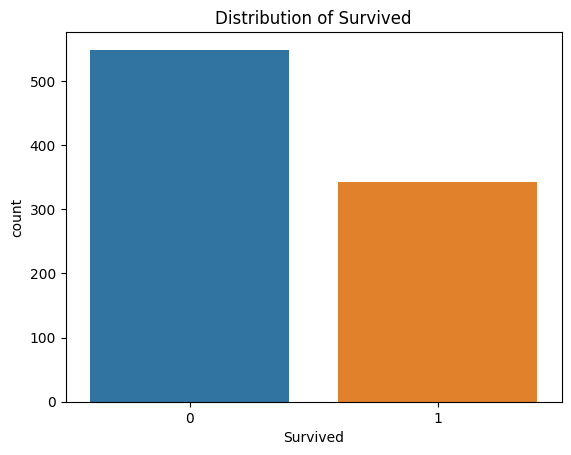

In [12]:
# Explore the distribution of the target variable 'Survived'
sns.countplot(data=train_df, x='Survived')
plt.title('Distribution of Survived')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


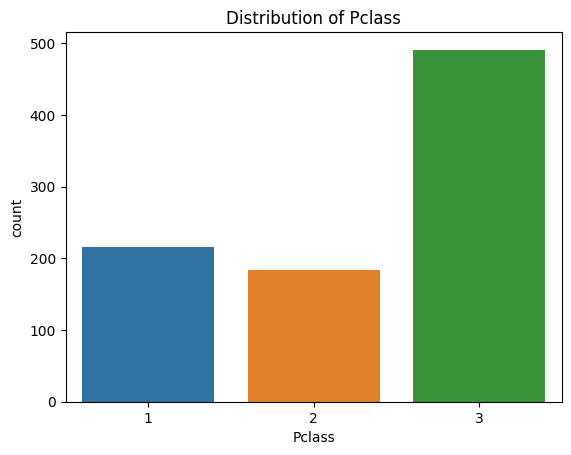

In [13]:
# Explore the distribution of 'Pclass'
sns.countplot(data=train_df, x='Pclass')
plt.title('Distribution of Pclass')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


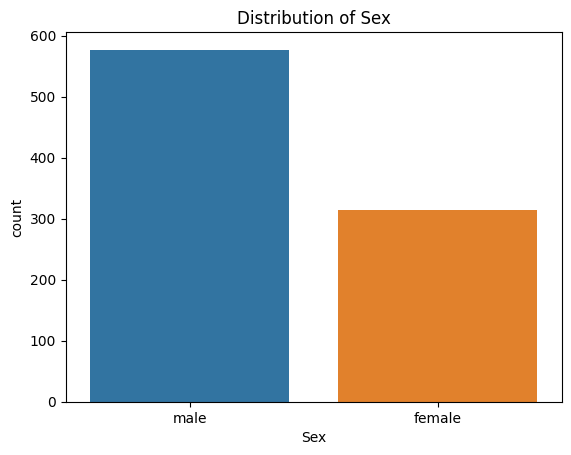

In [14]:
# Explore the distribution of 'Sex'
sns.countplot(data=train_df, x='Sex')
plt.title('Distribution of Sex')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


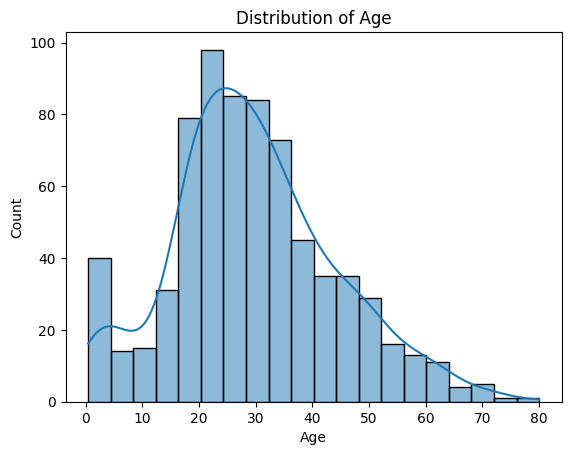

In [15]:
# Explore the distribution of 'Age'
sns.histplot(data=train_df, x='Age', kde=True)
plt.title('Distribution of Age')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


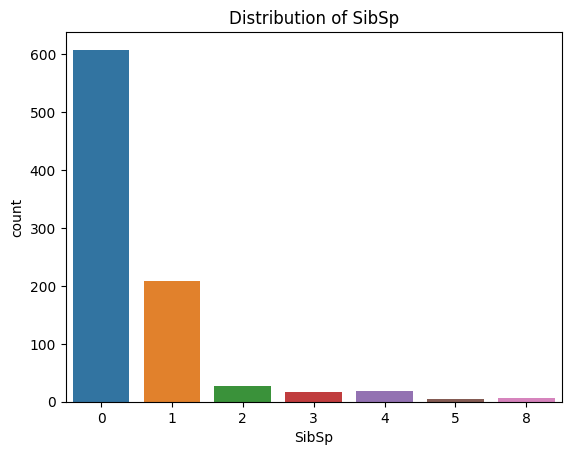

In [16]:
# Explore the distribution of 'SibSp' (number of siblings/spouses)
sns.countplot(data=train_df, x='SibSp')
plt.title('Distribution of SibSp')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


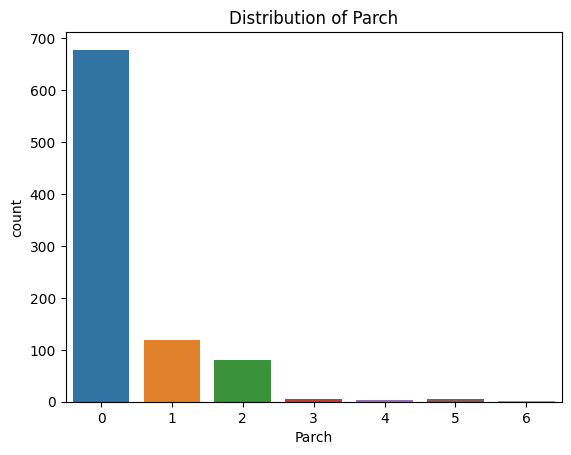

In [17]:
# Explore the distribution of 'Parch' (number of parents/children)
sns.countplot(data=train_df, x='Parch')
plt.title('Distribution of Parch')
plt.show()


/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


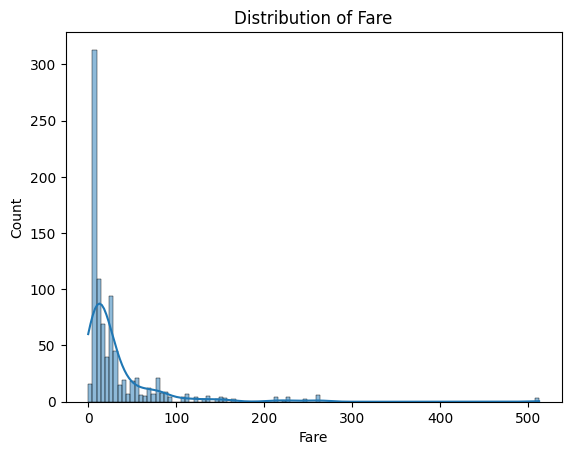

In [18]:
# Explore the distribution of 'Fare'
sns.histplot(data=train_df, x='Fare', kde=True)
plt.title('Distribution of Fare')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

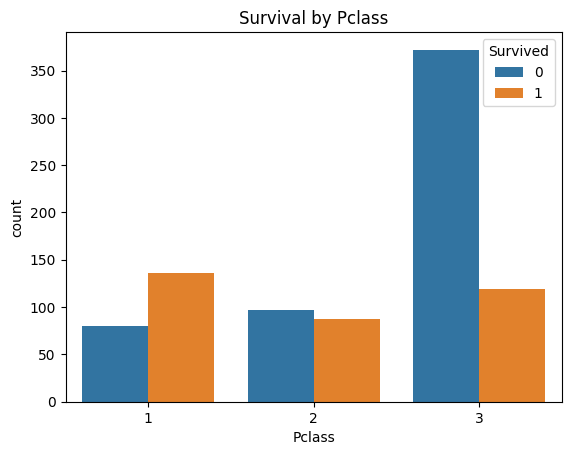

In [19]:
# Explore the relationship between 'Pclass' and 'Survived'
sns.countplot(data=train_df, x='Pclass', hue='Survived')
plt.title('Survival by Pclass')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

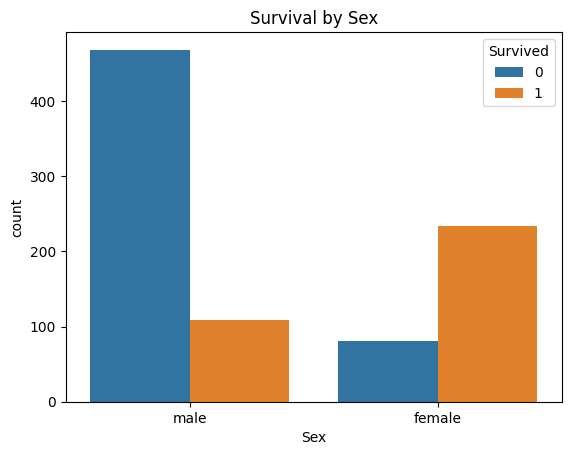

In [20]:
# Explore the relationship between 'Sex' and 'Survived'
sns.countplot(data=train_df, x='Sex', hue='Survived')
plt.title('Survival by Sex')
plt.show()

/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/link_dl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

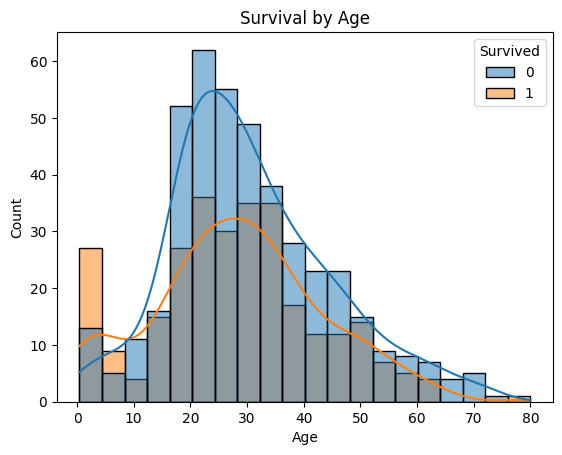

In [21]:
# Explore the relationship between 'Age' and 'Survived'
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True)
plt.title('Survival by Age')
plt.show()

# 2. Model

## 2-1. Define My Model Structure(provided prof.)

In [22]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output, activation=nn.ReLU()):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_input, 30),
            activation,
            nn.Linear(30, 30),
            activation,
            nn.Linear(30, n_output),
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    #modified code to comopare how activation function affect to model performance 

# 3. Train Code

## 3-1 provided train code

In [23]:
def train_and_evaluate(train_loader, validation_loader, model, optimizer, criterion, epochs):
    # Iterate over the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model in training mode
        total_loss = 0.0  # Initialize total loss for this epoch
        
        # Iterate over batches in the training DataLoader
        for batch in train_loader:
            inputs = batch['input']  # Get input data
            targets = batch['target']  # Get target data
            
            optimizer.zero_grad()  # Clear gradients from previous step
            
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update model parameters using the optimizer
            
            total_loss += loss.item()  # Accumulate the loss for this batch
        
        average_loss = total_loss / len(train_loader)  # Calculate the average training loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {average_loss:.4f}")  # Print the average loss for this epoch
        wandb.log({'Training Loss' : average_loss, 'Epoch' : epoch + 1})  # Log the training loss for visualization
    
        # Validation
        model.eval()  # Set the model in evaluation mode
        all_predictions = []  # List to store all predictions
        all_targets = []  # List to store all target values
        
        with torch.no_grad():
            # Iterate over batches in the validation DataLoader
            for batch in validation_loader:
                inputs = batch['input']  # Get input data
                targets = batch['target']  # Get target data
                
                outputs = model(inputs)  # Forward pass through the model
                predictions = torch.argmax(outputs, dim=1)  # Get class predictions
                
                all_predictions.extend(predictions.tolist())  # Collect all predictions
                all_targets.extend(targets.tolist())  # Collect all target values
        
        accuracy = accuracy_score(all_targets, all_predictions)  # Calculate accuracy
        wandb.log({'Validation Accuracy': accuracy * 100})  # Log the validation accuracy for visualization
        print(f"Validation Accuracy: {accuracy:.2f}%")  # Print the validation accuracy


# 3-2 train code for early stopping & Gradient Vanishing

In [24]:
from torch.nn.utils import clip_grad_norm_

def train_and_evaluate(train_loader, validation_loader, model, optimizer, criterion, epochs, patience=1000, max_grad_norm=1.0):
    # Initialize variables for early stopping
    best_val_loss = float('inf')  # Best validation loss initially set to positive infinity
    consecutive_no_improvement = 0  # Count of consecutive epochs with no improvement

    # Main training loop over epochs
    for epoch in range(epochs):
        model.train()  # Set the model in training mode
        total_loss = 0.0  # Initialize total loss for this epoch

        # Iterate over batches in the training DataLoader
        for batch in train_loader:
            inputs = batch['input']  # Get input data
            targets = batch['target']  # Get target data

            optimizer.zero_grad()  # Clear gradients from previous step

            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backpropagate the gradients

            # Apply gradient clipping to prevent gradient explosion
            clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()  # Update model parameters using the optimizer

            total_loss += loss.item()  # Accumulate the loss for this batch

        average_loss = total_loss / len(train_loader)  # Calculate the average training loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {average_loss:.4f}")  # Print the average loss for this epoch
        wandb.log({'Training Loss' : average_loss, 'Epoch' : epoch + 1})  # Log the training loss for visualization

        # Validation
        model.eval()  # Set the model in evaluation mode
        all_predictions = []  # List to store all predictions
        all_targets = []  # List to store all target values

        with torch.no_grad():
            val_loss = 0.0  # Initialize validation loss

            # Iterate over batches in the validation DataLoader
            for batch in validation_loader:
                inputs = batch['input']  # Get input data
                targets = batch['target']  # Get target data

                outputs = model(inputs)  # Forward pass through the model
                loss = criterion(outputs, targets)  # Calculate the loss
                val_loss += loss.item()  # Accumulate the validation loss

                predictions = torch.argmax(outputs, dim=1)  # Get class predictions

                all_predictions.extend(predictions.tolist())  # Collect all predictions
                all_targets.extend(targets.tolist())  # Collect all target values

            average_val_loss = val_loss / len(validation_loader)  # Calculate the average validation loss
            wandb.log({'Validation Loss': average_val_loss})  # Log the validation loss for visualization
            print(f"Validation Loss: {average_val_loss:.4f}")  # Print the validation loss

            accuracy = accuracy_score(all_targets, all_predictions)  # Calculate accuracy
            wandb.log({'Validation Accuracy': accuracy * 100})  # Log the validation accuracy for visualization
            print(f"Validation Accuracy: {accuracy:.2f}%")  # Print the validation accuracy

            # Check for early stopping
            if average_val_loss < best_val_loss:
                best_val_loss = average_val_loss  # Update the best validation loss
                consecutive_no_improvement = 0  # Reset the count of consecutive epochs with no improvement
            else:
                consecutive_no_improvement += 1  # Increment the count of consecutive epochs with no improvement

            # If validation loss hasn't improved for 'patience' consecutive epochs, stop training early
            if consecutive_no_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


1. Early Stopping Check
- The code checks whether the current average validation loss (average_val_loss) is better (lower) than the previously best validation loss (best_val_loss).
- If the validation loss has improved, best_val_loss is updated to the new lower value, and consecutive_no_improvement is reset to 0.
- If the validation loss has not improved, consecutive_no_improvement is incremented by 1.

2. Early Stopping Trigger:
- If consecutive_no_improvement exceeds the specified patience value, early stopping is triggered.
- Early stopping means that the training loop is terminated, even if the specified number of epochs has not been reached.
- A message is printed indicating the early stopping event.

3. In summary, the early stopping strategy continually monitors the validation loss during training. If the validation loss does not improve for a certain number of consecutive epochs (determined by patience), training is halted to prevent overfitting and to save time and resources. This ensures that the model is saved at the point where it generalizes best to unseen data.






# 4. Test Code

In [25]:
def test(test_data, model):
    print("[TEST]")
    predictions = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_data:
            inputs = batch['input']
            outputs = model(inputs)
            predictions_batch = torch.argmax(outputs, dim=1)
            predictions.extend(predictions_batch.tolist())
    
    return predictions

In [26]:
if __name__ == "__main__":
    wandb.init(project='HW-2')
    # Load and preprocess the data
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
    
    # Create data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    
    # Define model parameters
    n_input = len(train_dataset[0]['input'])
    n_output = 2  # Number of classes (Survived or Not Survived)
    
    # Define a list of activation functions to compare
    activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.LeakyReLU()]
    
    best_model = None
    best_activation_function = None
    best_acc = 0.0  # Initialize best accuracy
    
    for activation_function in activation_functions:
        print(f"Testing with Activation Function: {activation_function.__class__.__name__}")
        
        # Create and initialize the model
        model = MyModel(n_input=n_input, n_output=n_output, activation=activation_function)
        
        # Visualize the computational graph
        dummy_input = torch.randn(1, n_input)  # Create a dummy input tensor
        graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
        graph.render("FCN_graph", format="png")         
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training
        epochs = 100  # You can adjust the number of training epochs
        train_and_evaluate(train_loader, validation_loader, model, optimizer, criterion, epochs)
        
        # Testing
        predictions = test(test_loader, model)
    
        # Create a DataFrame for submission
        submission_df = pd.DataFrame({
            'PassengerId': list(range(892, 892 + len(predictions))),
            'Survived': predictions
        })
        
        # Save the submission CSV file with activation function name in the filename
        submission_filename = f'submission_{activation_function.__class__.__name__}.csv'
        submission_df.to_csv(submission_filename, index=False)
        print(f"Submission file '{submission_filename}' created.")    


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ydj9805. Use `wandb login --relogin` to force relogin


Testing with Activation Function: ReLU
Epoch [1/100] - Loss: 0.7334
Validation Loss: 0.6025
Validation Accuracy: 0.71%
Epoch [2/100] - Loss: 0.6208
Validation Loss: 0.6177
Validation Accuracy: 0.72%
Epoch [3/100] - Loss: 0.6191
Validation Loss: 0.5485
Validation Accuracy: 0.71%
Epoch [4/100] - Loss: 0.5872
Validation Loss: 0.6614
Validation Accuracy: 0.71%
Epoch [5/100] - Loss: 0.5911
Validation Loss: 0.5840
Validation Accuracy: 0.71%
Epoch [6/100] - Loss: 0.5763
Validation Loss: 0.5730
Validation Accuracy: 0.72%
Epoch [7/100] - Loss: 0.5888
Validation Loss: 0.5448
Validation Accuracy: 0.74%
Epoch [8/100] - Loss: 0.5765
Validation Loss: 0.5336
Validation Accuracy: 0.73%
Epoch [9/100] - Loss: 0.5561
Validation Loss: 0.5528
Validation Accuracy: 0.71%
Epoch [10/100] - Loss: 0.5658
Validation Loss: 0.4918
Validation Accuracy: 0.75%
Epoch [11/100] - Loss: 0.5430
Validation Loss: 0.5151
Validation Accuracy: 0.75%
Epoch [12/100] - Loss: 0.5447
Validation Loss: 0.5444
Validation Accuracy: 0.72

# MY DESIGN MODEL With Wandb

In [58]:
class Titanicnn(nn.Module):
    def __init__(self, n_input, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes,activation):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_input, hidden_size1),
            activation,
            nn.Linear(hidden_size1, hidden_size2),
            nn.Dropout(0.2),
            nn.Linear(hidden_size2, hidden_size3),
            activation,
            nn.Linear(hidden_size3, hidden_size4),
            nn.Dropout(0.2),
            nn.Linear(hidden_size4, num_classes),
            nn.Dropout(0.2)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    #modified code to comopare how activation function affect to model performance a

In [64]:
def get_model_and_optim():
    activation_functions = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(),
        "Sigmoid": nn.Sigmoid(),
        "Tanh": nn.Tanh()
    }
    my_model = Titanicnn(n_input = len(train_dataset[0]['input']),
                       hidden_size1 = wandb.config.n_hidden_unit_list[0],
                       hidden_size2 = wandb.config.n_hidden_unit_list[1],
                       hidden_size3 = wandb.config.n_hidden_unit_list[2],
                       hidden_size4 = wandb.config.n_hidden_unit_list[3],
                       num_classes = 2,
                       activation= activation_functions[wandb.config.activation])
    
    optimizer = optim.SGD(my_model.parameters(), lr = wandb.config.learning_rate)
    
    return my_model, optimizer

In [118]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.CrossEntropyLoss()
    next_print_epoch = 100
    
    for epoch in range (1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0
        
        for train_batch in train_data_loader:
            output_train = model(train_batch['input'])
            loss = loss_fn(output_train, train_batch['target'])
            loss_train += loss.item()
            print(loss_train)
            num_trains += 1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    loss_validation = 0.0
    num_validations = 0
    
    with torch.no_grad():
        for validation_batch in validation_data_loader:
            output_validation = model(validation_batch['input'])
            loss = loss_fn(output_validation, validation_batch['target'])
            loss_validation += loss.item()
            num_validations +=1
            
    wandb.log({
        "Epoch" : epoch, 
        "Training loss" : loss_train / num_trains,
        "Validation loss" : loss_validation / num_validations
    })
    
    if epoch >= next_print_epoch:
        print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
        next_print_epoch += 100

In [119]:
def get_data():
    train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
    validation_loader = DataLoader(dataset = validation_dataset, batch_size = 16, shuffle= False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    
    return train_loader, validation_loader, test_loader
    

In [120]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    config = {
        'epochs' : args.epochs,
        'batch_size' : args.batch_size,
        'learning_rate' : args.lr,
        'n_hidden_unit_list' : [20, 30, 10, 15],
        'activation' : args.active
    }
    
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = "My_Model_Test",
        notes = "hello wandb world",
        tags = ["Test", "Titanic"]   ,
        name = current_time_str,
        config = config
    )
    
    print(args)
    print(wandb.config)
    
    train_loader, validation_loader, test_loader = get_data()
    
    linear_model, optimizer = get_model_and_optim()

    wandb.watch(linear_model)
    
    print('-' * 50, 1)
    
    training_loop(
        model = linear_model,
        optimizer = optimizer,
        train_data_loader=train_loader,
        validation_data_loader= validation_loader    
    )
    wandb.finish()



In [121]:
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()

    parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
    )

    parser.add_argument(
    "-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)"
    )

    parser.add_argument(
    "-e", "--epochs", type=int, default=1_000, help="Number of training epochs (int, default:1_000)"
    )

    parser.add_argument(
    "-a", "--active", choices=activation_functions.keys(), default= "ReLU", help="activation function"
    )

    parser.add_argument(
        "-l", "--lr", type = float, default = 0.001, help = 'learning rate'
    )
    # args = parser.parse_args()
    # in jupyter we have to use belowed code
    args = parser.parse_args(args=[])

    main(args)

Namespace(wandb=False, batch_size=512, epochs=1000, active='ReLU', lr=0.001)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 30, 10, 15], 'activation': 'ReLU'}
-------------------------------------------------- 1
0.7576792240142822
1.6473217010498047
2.399475634098053
3.647597014904022
4.556623220443726
5.1593217849731445
5.76711630821228
6.710655212402344
7.582340657711029
9.045083701610565
9.845687627792358
10.78447276353836
11.712894260883331
12.871371448040009
13.699146151542664
14.604284524917603
15.285228729248047
15.894055962562561
16.52685695886612
17.448412120342255
18.131044507026672
18.897845149040222
19.6006920337677
20.419634521007538
21.256443083286285
22.11685347557068
22.940179646015167
23.776595175266266
24.404323160648346
25.02995127439499
25.95407259464264
26.75298810005188
27.5598806142807
28.33090490102768
28.9413743019104
29.878771781921387
30.561055779457092
31.306577801704407
32.02142691612244
33.360872983932495
34.03344100